# **Introduction**

What is Parkinson's Disease?

Parkinson's disease (PD), or simply Parkinson's is a long-term degenerative disorder of the central nervous system that mainly affects the motor system. The symptoms usually emerge slowly and, as the disease worsens, non-motor symptoms become more common. The most obvious early symptoms are tremor, rigidity, slowness of movement, and difficulty with walking,but cognitive and behavioral problems may also occur. Parkinson's disease dementia becomes common in the advanced stages of the disease. Depression and anxiety are also common, occurring in more than a third of people with PD. Other symptoms include sensory, sleep, and emotional problems. The main motor symptoms are collectively called "parkinsonism", or a "parkinsonian syndrome

![](https://camo.githubusercontent.com/be21545deabab1e7257c04182b631f6f34ebae4b/68747470733a2f2f7061726b696e736f6e736e65627261736b612e6f72672f77702d636f6e74656e742f75706c6f6164732f323032302f30332f50442d4d414e2d31303234783532322e706e67)

While Parkinson’s disease cannot be cured, early detection along with proper medication can significantly improve symptoms and quality of life, making it an important topic for research especially in the creation of new diagnostic tools.

A 2017 study by Zham et al. found that it was possible to detect Parkinson’s by asking the patient to draw a spiral and then track:

 1. Speed of drawing
 2. Pen pressure

The researchers found that the drawing speed was slower and the pen pressure lower among Parkinson’s patients — this was especially pronounced for patients with a more acute/advanced forms of the disease.

We’ll be leveraging the fact that two of the most common Parkinson’s symptoms include tremors and muscle rigidity which directly impact the visual appearance of a hand drawn spiral and wave.

The variation in visual appearance will enable us to train a computer vision + machine learning algorithm to automatically detect Parkinson’s disease.


# **Dataset Description**

The dataset we’ll be using here today was curated by Adriano de Oliveira Andrade and Joao Paulo Folado from the NIATS of Federal University of Uberlândia.

The dataset itself consists of images and is pre-split into a training set and a testing set, consisting of:

Spiral: training, and testing

Wave: training, and testing

![](https://camo.githubusercontent.com/454ee9a31a3b087992584258f97b5b4a77d87dc7/68747470733a2f2f7079696d6167657365617263682e636f6d2f77702d636f6e74656e742f75706c6f6164732f323031392f30342f6465746563745f7061726b696e736f6e735f646174617365742e6a7067)

**Approach**

Although Deep learning with Convolutional Neural networks seems to be the best approach for this computer vision problem, we have a limited amount of training data and we cannot apply data augmentation as it will lead to a distortion of the results. With this in mind we will rather apply the Histogram of Oriented Gradients Image Descriptor with an ensemble method i.e., Random Forest Classifier and Xgboost

# **Load the data and extract the features**

In [1]:
import os
import cv2
import numpy as np
from skimage import feature
import random
import matplotlib.pyplot as plt
%matplotlib inline

**Quantify the image using a HOG Descriptor**

HOG is a structural descriptor that will capture and quantify changes in local gradient in the input image. HOG will naturally be able to quantify how the directions of a both spirals and waves change. And furthermore, HOG will be able to capture if these drawings have more of a “shake” to them, as we might expect from a Parkinson’s patient.

The resultant feature vector will then be used to train the classifier

In [2]:
def quantify_image(image):
    features = feature.hog(image, orientations=9,
                           pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                           transform_sqrt=True, block_norm="L1")
    return features

In [3]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image
        features = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

# **Training the Models**

In [4]:
# pip install imutils

In [5]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix

In [6]:
def train_models(dataset):
    # initialize the models
    models = {
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
        }
    }
    # define the path to the testing and training directories
    path = "./drawings/" + dataset
    trainingPath = os.path.sep.join([path, "training"])
    testingPath = os.path.sep.join([path, "testing"])
    # load the data
    (trainX, trainY) = load_split(trainingPath)
    (testX, testY) = load_split(testingPath)
    # encode the labels
    le = LabelEncoder()
    trainY = le.fit_transform(trainY)
    testY = le.transform(testY)

    # train each model and calculate its metrics
    for model in models:
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        cm = confusion_matrix(testY, predictions).ravel()
        tn, fp, fn, tp = cm
        models[model]["accuracy"] = (tp + tn) / float(cm.sum())
        models[model]["sensitivity"] = tp / float(tp + fn)
        models[model]["specificity"] = tn / float(tn + fp)

    return models

In [7]:
# Train the models on the spiral drawings
spiralModels = train_models('spiral')

In [8]:
# train the model on the wave-form drawings
waveModels = train_models('wave')

# **Models Performance**

**Spiral Drawings**

In [9]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        spiralModels['Rf'][metric]*100, spiralModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=80.00%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=66.67%, XGBoost=73.33% 

Specificity: 
Random Forrest=93.33%, XGBoost=73.33% 



**Wave Drawings**

In [10]:
print("Random Forrest vs XGBoost Classifier\n\n")
for metric in ("accuracy", "sensitivity", "specificity"):
    print(f"{metric.capitalize()}: ")
    print("Random Forrest={:.2f}%, XGBoost={:.2f}% \n".format(
        waveModels['Rf'][metric]*100, waveModels['Xgb'][metric]*100))

Random Forrest vs XGBoost Classifier


Accuracy: 
Random Forrest=63.33%, XGBoost=73.33% 

Sensitivity: 
Random Forrest=53.33%, XGBoost=80.00% 

Specificity: 
Random Forrest=73.33%, XGBoost=66.67% 



# **Testing On Sample Images and Visualize the predictions**

In [11]:
def test_prediction(model, testingPath):
    # get the list of images
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    # pick 15 images at random
    for _ in range(15):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted features
        features = quantify_image(image)
        preds = model.predict([features])
        label = "Parkinsons" if preds[0] else "Healthy"

        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (0, 255, 0) if label == "Healthy" else (0, 0, 255)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

**Spiral images**

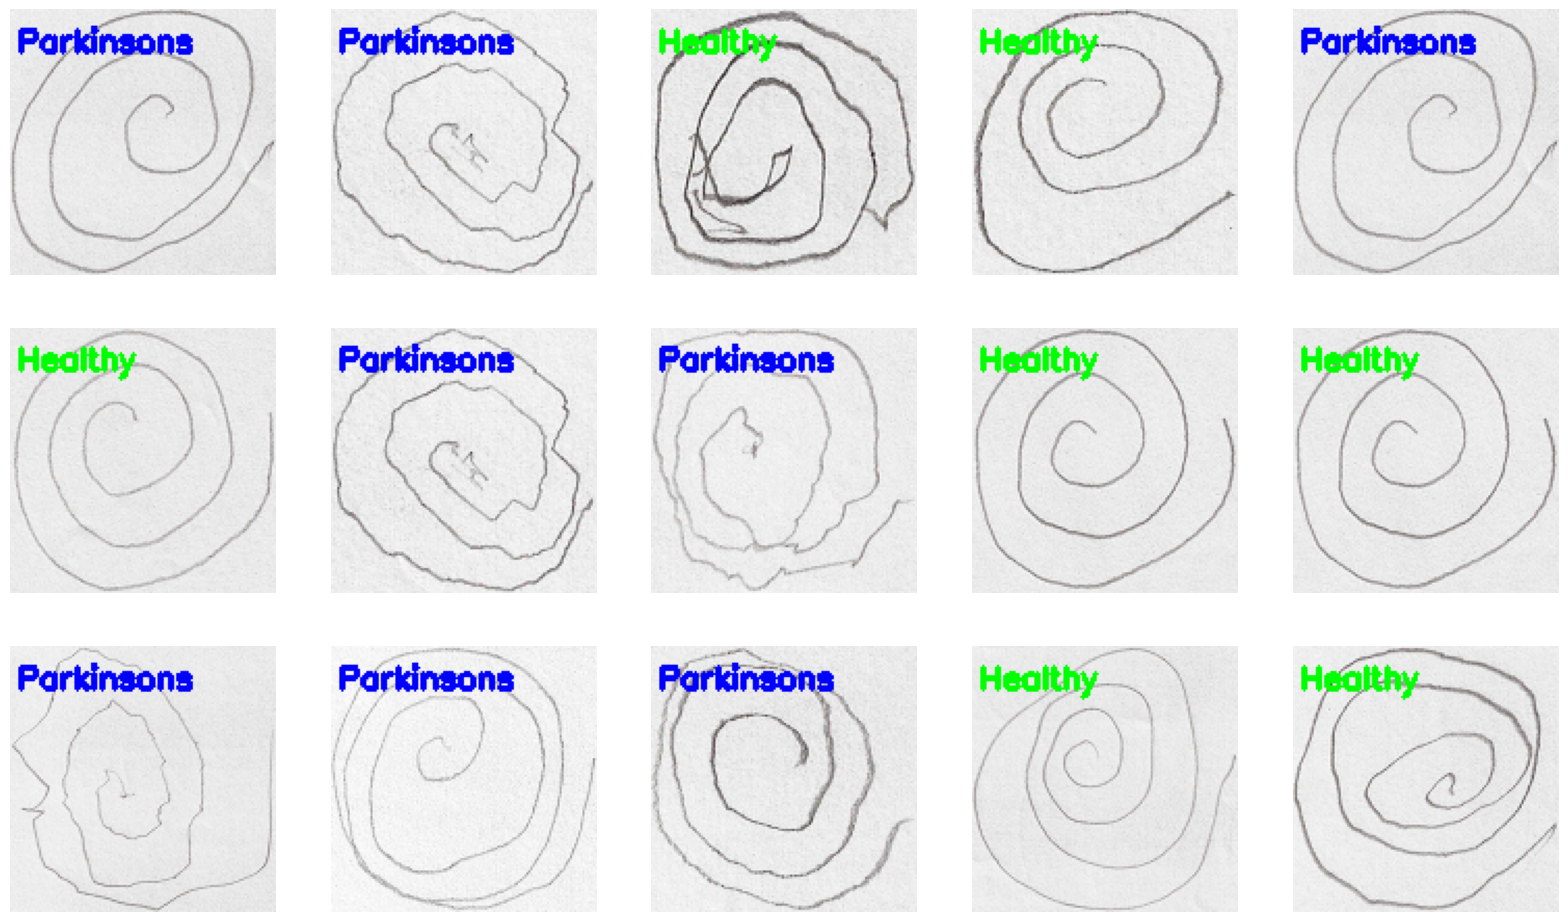

In [12]:
testingPath = os.path.sep.join(["./drawings/spiral", "testing"])
test_prediction(spiralModels['Rf']['classifier'], testingPath)

**Wave Images**

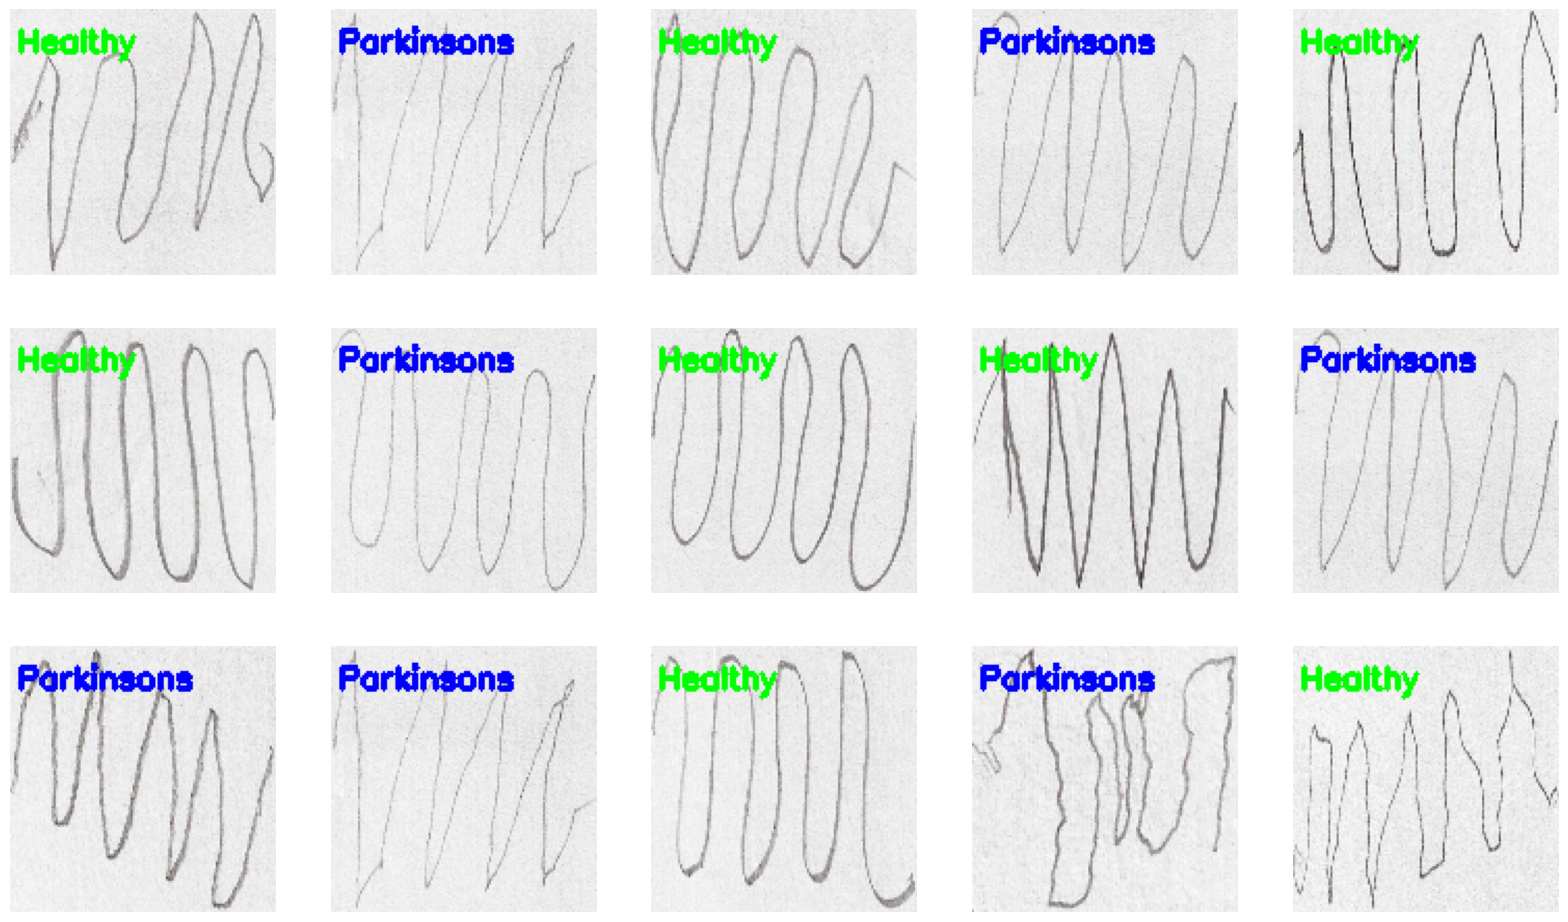

In [13]:
testingPath = os.path.sep.join(["./drawings/wave", "testing"])
test_prediction(waveModels['Rf']['classifier'], testingPath)